# Pecipitation and the Mid-Latitude Seasonal Oscillation (MLSO) index
### Zak M

#### Importing dependencies

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

#### Loading precip data

In [2]:
path = '/scratch/zmanthos/thesis/'
file = 'gpcp.lat25-55N.lon130-50W.nc'
files = path+file
data = xr.open_dataset(files,decode_times=True,decode_cf=True)
print(data)

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 31, longitude: 81, time: 8038)
Coordinates:
  * latitude        (latitude) float32 25.0 26.0 27.0 28.0 ... 53.0 54.0 55.0
  * longitude       (longitude) float32 230.0 231.0 232.0 ... 308.0 309.0 310.0
  * time            (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2018-12-31
Dimensions without coordinates: bnds
Data variables:
    longitude_bnds  (time, longitude, bnds) float32 ...
    latitude_bnds   (time, latitude, bnds) float32 ...
    time_bnds       (time, bnds) datetime64[ns] ...
    precip          (time, latitude, longitude) float32 ...
Attributes:
    CDI:                        Climate Data Interface version 1.8.2 (http://...
    history:                    Thu Sep 17 20:06:27 2020: cdo cat /scratch/zm...
    source:                     /data1/GPCP_CDR/GPCP_Output/1DD//bin/199610/s...
    institution:                ACADEMIC > UMD/ESSIC > Earth System Science I...
    Conventions:                CF-1.6, ACDD 1.3
 

#### Loading the MLSO index

In [3]:
path1 = '/homes/zmanthos/thesis/index/'
file1 ='mlso.index.01011979-08312019.nc'
mlso = xr.open_dataset(path1+file1,decode_times=True,decode_cf=True)
mlso = mlso.sel(time=slice('1997-01-01','2018-12-31'))
print(mlso)

<xarray.Dataset>
Dimensions:  (time: 8035)
Coordinates:
  * time     (time) datetime64[ns] 1997-01-01 1997-01-02 ... 2018-12-31
Data variables:
    mlso     (time) float64 ...


#### Creating the Different Bins of the index

In [4]:
positive=mlso['mlso'].where(mlso['mlso']>=1).dropna(dim='time')
negative=mlso['mlso'].where(mlso['mlso']<=-1).dropna(dim='time')
neutral=mlso['mlso'].where(np.logical_and(mlso['mlso']>-1,mlso['mlso']<1)).dropna(dim='time')
print(len(positive['time']),len(negative['time']),len(neutral['time']))


975 1192 5868


#### Computing Anomalies

In [5]:
clima = data.groupby('time.dayofyear').mean()
anoms = data.groupby('time.dayofyear') - clima;

#### Cutting and averaging data for each bin

In [6]:
negs = data.sel(time=negative.dropna(dim='time')['time']).mean(dim='time')
# can't figure out why this wasn't working

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

#### Work-around 

In [7]:
pos = anoms.where(anoms['time'].isin(positive['time'].values)).dropna(dim='time',thresh=1000)
neg = anoms.where(anoms['time'].isin(negative['time'].values)).dropna(dim='time',thresh=1000)
neu = anoms.where(anoms['time'].isin(neutral['time'].values)).dropna(dim='time',thresh=1000)
print(len(pos['time']),len(neg['time']),len(neu['time']))

975 1192 5868


#### Justification for the threshold

In [8]:
tts = 0;
for x in range(0,975):
    pt1 = positive['time'][x]
    pt2 = pos['time'][x]
    truth = (pt1==pt2)
    if truth == True:
        tts+=1;
    else:
        print('\n FALSE: ', pt1.values,pt2.values,'\n')
pos = pos.mean(dim='time')
print('Positive date truths:',tts,' \n')
tts = 0;
for x in range(0,1192):
    pt1 = negative['time'][x]
    pt2 = neg['time'][x]
    truth = (pt1==pt2)
    if truth == True:
        tts+=1;
    else:
        print('\n FALSE: ', pt1.values,pt2.values,'\n')
neg = neg.mean(dim='time')
print('Negative date truths:',tts,' \n')
tts = 0;
for x in range(0,5868):
    pt1 = neutral['time'][x]
    pt2 = neu['time'][x]
    truth = (pt1==pt2)
    if truth == True:
        tts+=1;
    else:
        print('\n FALSE: ', pt1.values,pt2.values,'\n')
neu = neu.mean(dim='time')
print('Neutral date truths:',tts,' \n')

Positive date truths: 975  

Negative date truths: 1192  

Neutral date truths: 5868  



### Graphing of Composites

Text(0.5, 0.98, 'Composite Precipitation Anomalies for the MLSO index')

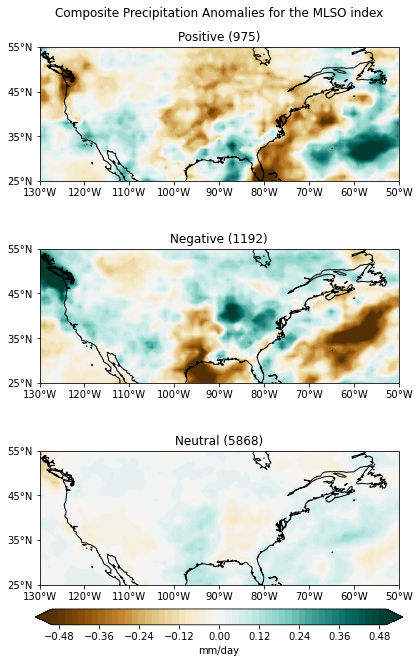

In [9]:
precip_bins = [pos,neg,neu];
lengths = [len(positive),len(negative),len(neutral)]
labels=['Positive','Negative', 'Neutral']
levels=np.linspace(-0.5,0.5,51)

fig, axs = plt.subplots(nrows=3,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(8.5,11))

axs=axs.flatten()

n=0;
for enso in enumerate(precip_bins):
        data=precip_bins[n]['precip']
        cs=axs[n].contourf(precip_bins[n]['longitude'],precip_bins[n]['latitude'],data,levels=levels,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

        axs[n].set_xticks(np.arange(-130,-49,10), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[n].xaxis.set_major_formatter(lon_formatter)

        axs[n].set_yticks(np.arange(25,56,10), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[n].yaxis.set_major_formatter(lat_formatter)

        axs[n].set_title(labels[n]+' ('+str(lengths[n])+')')
        axs[n].coastlines()
        n+=1;

fig.subplots_adjust(bottom=0.25, top=0.93, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='mm/day')
plt.suptitle('Composite Precipitation Anomalies for the MLSO index')